In [1]:
import pandas as pd
import numpy as np

traindata = pd.read_csv('/content/datatrain.csv')
traindata.head()

,id,video,emotion
0,1,https://www.instagram.com/reel/DNKcHgdA-d1/?ig...,Surprise
1,2,https://www.instagram.com/reel/DNHwrh2gnBm/?ig...,Surprise
2,3,https://www.instagram.com/reel/DM7QsjnRCoa/?ig...,Surprise
3,4,https://www.instagram.com/reel/DNBBEt6Paxj/?ig...,Surprise
4,5,https://www.instagram.com/reel/DMz13fQzZsN/?ig...,Proud


In [2]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       803 non-null    int64 
 1   video    803 non-null    object
 2   emotion  803 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.9+ KB


In [3]:
traindata['emotion'].value_counts()

,count
emotion,
Surprise,320
Trust,181
Proud,154
Joy,53
Anger,34
Sadness,17
Fear,16
Neutral,8
Terkjut,3


In [4]:
#Mapping buat benerin labelnya

mapping = {
    'Proud': 'Proud', 'Bangga': 'Proud',
    'Trust': 'Trust', 'Percaya': 'Trust', 'Faith': 'Trust', 'Loyalty': 'Trust',
    'Joy': 'Joy', 'Love': 'Joy',
    'Surprise': 'Surprise', 'Terkjut': 'Surprise', 'Terkejut': 'Surprise',
    'Trkejut': 'Surprise', 'kaget': 'Surprise', 'Kaget': 'Surprise',
    'Trekejut': 'Surprise', 'terkejut': 'Surprise',
    'Neutral': 'Neutral',
    'Sadness': 'Sadness', 'Sad': 'Sadness',
    'Fear': 'Fear',
    'Anger': 'Anger', 'Marh': 'Anger', 'Marah': 'Anger'
}

traindata['emotion'] = traindata['emotion'].map(mapping)

In [5]:
traindata['emotion'].value_counts()

,count
emotion,
Surprise,331
Trust,184
Proud,156
Joy,54
Anger,36
Sadness,18
Fear,16
Neutral,8


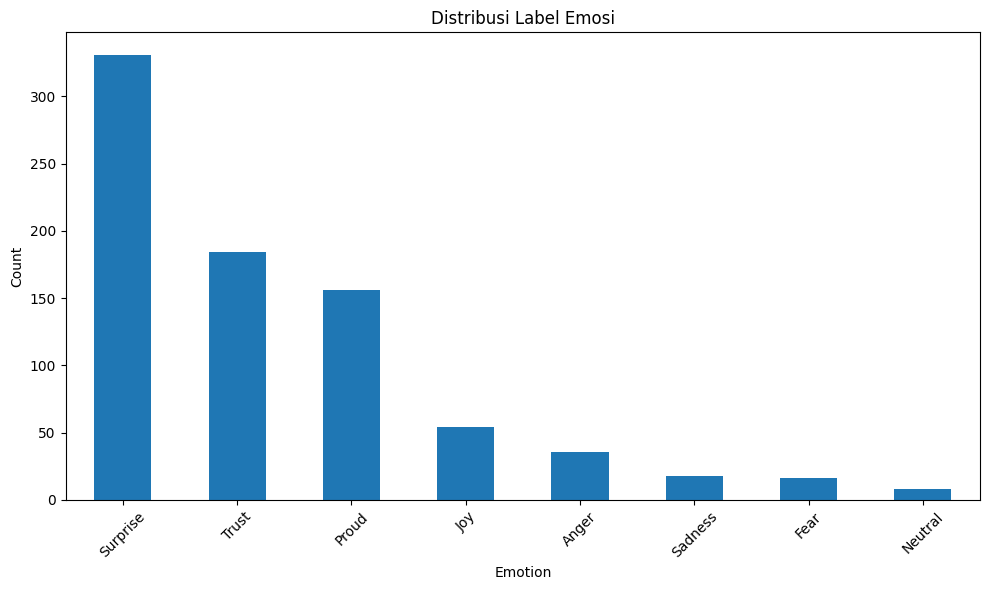

In [6]:
import matplotlib.pyplot as plt

label_counts = traindata['emotion'].value_counts()

plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribusi Label Emosi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
traindata.to_csv("traindatafix.csv")

In [ ]:
import os
import pandas as pd
import re
import time
from yt_dlp import YoutubeDL
import gdown
from tqdm import tqdm

# === Konfigurasi ===
CSV_PATH = "/content/traindatafix.csv"    # CSV sumber data
BASE_DIR = "/content/data"                # Folder output
COOKIE_FILE = "/content/cookie.txt"       # File cookies Instagram (format Netscape)
BATCH_SIZE = 100                          # jumlah video per batch
SLEEP_MIN = 2                             # jeda minimal antar download
SLEEP_MAX = 5                             # jeda maksimal antar download

# Baca CSV
df = pd.read_csv(CSV_PATH)
required_cols = {"id", "video", "emotion"}
if not required_cols.issubset(df.columns):
    raise ValueError(f"CSV harus mengandung kolom {required_cols}")

# Buat folder per label emosi
for label in sorted(df['emotion'].unique()):
    os.makedirs(os.path.join(BASE_DIR, str(label)), exist_ok=True)

failed_ids = []

def download_drive(url, save_path):
    match = re.search(r'/d/([^/]+)', url)
    if match:
        file_id = match.group(1)
        direct_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    else:
        direct_url = url
    gdown.download(direct_url, save_path, quiet=False)

def download_instagram(url, save_path):
    ydl_opts = {
        'outtmpl': save_path,
        'format': 'mp4',
        'cookiefile': COOKIE_FILE,
        'quiet': True,
        'continuedl': True,               # lanjutkan jika terputus
        'sleep_interval': SLEEP_MIN,
        'max_sleep_interval': SLEEP_MAX
    }
    with YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

# Loop download dengan batching
for start in range(0, len(df), BATCH_SIZE):
    end = min(start + BATCH_SIZE, len(df))
    batch_df = df.iloc[start:end]

    print(f"\n🚀 Memproses batch {start+1}–{end} dari {len(df)} total\n")
    for _, row in tqdm(batch_df.iterrows(), total=len(batch_df)):
        video_id = row['id']
        url = str(row['video'])
        emotion_label = str(row['emotion'])
        save_path = os.path.join(BASE_DIR, emotion_label, f"{video_id}.mp4")

        try:
            if "instagram.com" in url:
                download_instagram(url, save_path)
            elif "drive.google.com" in url:
                download_drive(url, save_path)
            else:
                print(f"[SKIP] {video_id} - URL tidak dikenali")
            # jeda antar file
            time.sleep(SLEEP_MIN)
        except Exception as e:
            print(f"[GAGAL] {video_id}: {e}")
            failed_ids.append(video_id)

    print("⏳ Istirahat antar batch ±60 detik...")
    time.sleep(60)

# Simpan daftar gagal
if failed_ids:
    with open("failed.txt", "w") as f:
        f.write("\n".join(map(str, failed_ids)))
    print(f"❌ {len(failed_ids)} video gagal. Lihat daftar di failed.txt")
else:
    print("✅ Semua video berhasil diunduh")